# Projet 10 : Analyse du jeu de données.

Dans ce carnet, nous étudierons le jeu de données *News Portal - by Globo.com* afin de l'utiliser comme base pour l'entraînement des systèmes de recommandation.

Nous nous concentrerons sur :
* Le dossier **clicks**, qui contient les fichiers .CSV répertoriant les interactions des utilisateurs sur le portail Globo.com (un fichier par heure) ;
* Le fichier .CSV **articles_metadata**, qui contient les métadonnées de tous les articles publiés (364 047) ;
* Le fichier **articles_embeddings.pickle** contenant les intégrations des articles (vecteurs de dimensions 250), entraînées sur le texte et les métadonnées des articles OGlobo (https://github.com/gabrielspmoreira/chameleon_recsys).

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import os
import pickle
from time import time
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Chemin du Dataset

Commençons par définir quelques chemins clés pour accéder à l'ensemble de données

In [2]:
src_path = Path("/home/maxime/openclassrooms/projet10_data/news-portal-user-interactions-by-globocom")
click_path = Path("/home/maxime/openclassrooms/projet10_data/news-portal-user-interactions-by-globocom/clicks/clicks")

# 2. Exploration du Dataset : clicks folder

Chargeons tous les fichiers du dossier « Clics » pour avoir un aperçu des données disponibles. Nous concaténerons tous ces fichiers pour former le dataframe d'interaction.

In [4]:
def get_interaction_dataset(click_path: Path) -> pd.DataFrame:
    """Obtenir un dataset concaténé."""
    click_filelist = sorted(click_path.iterdir(), key=lambda x: x.name)
    click_list = []
    for i in range(0, len(click_filelist)):
        temp = pd.read_csv(click_path / click_filelist[i])
        temp['filename'] = i
        click_list.append(temp)
    clicks = pd.concat(click_list, axis=0, ignore_index=True)

    clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)
    date2convert = ['session_start', 'click_timestamp']
    for col in date2convert:
        clicks[col] = pd.to_datetime(clicks[col], unit='ms')
    return clicks

clicks = get_interaction_dataset(click_path=click_path)

In [5]:
print('Données de clics: ', clicks.shape)    

Données de clics:  (2988181, 13)


In [6]:
clicks.head()

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,filename
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2,0
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2,0
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2,0
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2,0
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2,0


Examinons maintenant les variables du dataframe d'interaction.

* **user_id** : identifiant unique de l'utilisateur
* **session_id** : identifiant unique de la session ; au cours d'une session, un utilisateur peut avoir consulté plusieurs articles ;
* **session_start** : horodatage de la première interaction de la session ;
* **session_size** : nombre d'interactions au cours de la session ;
* **click_article_id** : article consulté par l'utilisateur (1 ou plusieurs) ;
* **click_timestamp** : horodatage de l'interaction ;
* **click_environment** : identifiant de l'environnement (1 - Facebook, 2 - Application mobile, 3 - Pages mobiles, 4 - Web) ;
* **click_deviceGroup** : type d'appareil utilisé (1 - Tablette, 2 - Téléviseur, 4 - Mobile, 5 - Ordinateur ou 3 - Vide) ; * **click_os** : identifiant du système d’exploitation (1 - Autre, 2 - iOS, 3 - Android, 4 - Windows Phone, 5 - Windows Mobile, 6 - Windows, 7 - Mac OS X, 8 - Mac OS, 9 - Samsung, 10 - FireHbbTV, 11 - ATV OS X, 12 - tvOS, 13 - Chrome OS, 14 - Debian, 15 - Symbian OS, 16 - BlackBerry OS, 17 - Firefox OS, 18 - Android, 19 - Brew MP, 20 - Chromecast, 21 - webOS, 22 - Gentoo, 23 - Solaris) ;
* **click_country** : identifiant du pays ;
* **click_region** : région ;
* **click_referrer_type** : (Aucune information).

## 2.1. Valeur unique dans le dataset interaction

In [8]:
print('=== Valeur unique dans le dataset interaction ===')
print('=================================================================')
for col in clicks.columns:
    print(col, ' :', clicks[col].nunique())

=== Valeur unique dans le dataset interaction ===
user_id  : 322897
session_id  : 1048594
session_start  : 646874
session_size  : 72
article_id  : 46033
click_timestamp  : 2983198
click_environment  : 3
click_deviceGroup  : 5
click_os  : 8
click_country  : 11
click_region  : 28
click_referrer_type  : 7
filename  : 384


# 3. Exploration du dataset : articles_metadata.csv

Chargeons et affichons quelques informations clés de articles_metadata.csv

In [10]:
articles = pd.read_csv(src_path / 'articles_metadata.csv')

articles['created_at_ts'] = pd.to_datetime(
    (pd.to_datetime(
        articles['created_at_ts'],
        unit='ms')).dt.strftime('%Y/%m/%d'))
print('Date de création Min/Max :', articles['created_at_ts'].min(),
      '/ ', articles['created_at_ts'].max())

print('Métadonnées des articles: ', articles.shape)
articles.head()

Date de création Min/Max : 2006-09-27 00:00:00 /  2018-03-13 00:00:00
Métadonnées des articles:  (364047, 5)


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13,0,168
1,1,1,2014-07-14,0,189
2,2,1,2014-08-22,0,250
3,3,1,2014-08-19,0,230
4,4,1,2014-08-03,0,162


Examinons maintenant les variables du dataframe de métadonnées.

* **article_id** : l'identifiant de l'article ;
* **category_id** : l'identifiant de la catégorie de l'article ;
* **created_at_ts** : la date de publication de l'article ;
* **publisher_id** : l'identifiant de l'éditeur de l'article ;
* **word_count** : le nombre de mots par article.

## 3.1. Valeurs uniques dans le dataset metadata.

In [11]:
print('=== Valeurs uniques dans le dataset metadata ===')
print('=============================================================')
for col in articles.columns:
    print(col, ' :', articles[col].nunique())

=== Valeurs uniques dans le dataset metadata ===
article_id  : 364047
category_id  : 461
created_at_ts  : 2302
publisher_id  : 1
words_count  : 866


# 4. Exploration du dataset : embeddings pickle

Pour rappel, la matrice d'intégration est un vecteur de 250 dimensions, représentant généralement le poids des mots de vocabulaire utilisés dans un document - ici, les articles.

In [12]:
with open(os.path.join(src_path,'articles_embeddings.pickle'), 'rb') as file:
    embeddings = pickle.load(file)

df_embeddings = pd.DataFrame(embeddings)
df_embeddings = df_embeddings.add_prefix('dim_')

print('Articles embeddings shape: ', df_embeddings.shape)
df_embeddings.head()

Articles embeddings shape:  (364047, 250)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


**Observations clés :**
* 322 897 utilisateurs uniques ;
* 364 047 articles disponibles dans la base de données, mais seulement 46 033 font l’objet d’interactions avec les utilisateurs ;
* Près de 3 millions de clics sur les articles sur la période étudiée.

# 5. Principaux enseignements de l'ensemble de données

L'objectif du système de recommandation étant de fournir aux utilisateurs des articles qu'ils pourraient lire, nous pouvons considérer que les principaux éléments du système sont les **utilisateurs et les articles.**

## 5.1 Période d'analyse.

In [16]:
print('Sessions commence de {} à {}'.format(clicks.session_start.min(), clicks.session_start.max()))

Sessions commence de 2017-10-01 02:37:03 à 2017-10-17 03:36:19


In [17]:
print('Les clicks commence de {} à {}'.format(clicks.click_timestamp.min(), clicks.click_timestamp.max()))

Les clicks commence de 2017-10-01 03:00:00.026000 à 2017-11-13 20:04:14.886000


**Observations clés :**
* Les sessions débutent le 1er octobre 2017 et se terminent le 17 octobre 2017, soit une période de 16 jours ;
* La durée des sessions s'étend du 1er octobre 2017 au 13 novembre 2017.
* Ces deux données semblent quelque peu incohérentes, mais les dates de début des sessions devraient être plus fiables.

## 5.2 Durée de lecture de articles.

In [18]:
df0 = clicks[['user_id', 'session_id', 'session_start', 'click_timestamp']]

df1 = pd.DataFrame(
    df0.groupby(['user_id','session_id', 'session_start'],
                as_index=False)['click_timestamp'].diff().fillna(pd.Timedelta(seconds=0)))

df1.rename(columns={'click_timestamp':'delta_w_previous'}, inplace=True)

views = df0.join(df1)

views['end_article_view'] = views['click_timestamp'] - views['session_start']

views['view_duration'] = np.where(round(views['delta_w_previous'].dt.total_seconds(),0) == 0,
                             round(views['end_article_view'].dt.total_seconds(), 0),
                             round(views['delta_w_previous'].dt.total_seconds(), 0))

views.head()

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
0,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:28.020,0 days 00:00:00,0 days 00:23:25.020000,1405.0
1,0,1506825423271737,2017-10-01 02:37:03,2017-10-01 03:00:58.020,0 days 00:00:30,0 days 00:23:55.020000,30.0
2,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:03:37.951,0 days 00:00:00,0 days 00:26:31.951000,1592.0
3,1,1506825426267738,2017-10-01 02:37:06,2017-10-01 03:04:07.951,0 days 00:00:30,0 days 00:27:01.951000,30.0
4,2,1506825435299739,2017-10-01 02:37:15,2017-10-01 03:04:50.575,0 days 00:00:00,0 days 00:27:35.575000,1656.0


Regardons plus en détail 2 utilisateurs. N°68 et N°320431

In [19]:
views[views.user_id == 68]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
180,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:26:26.082,0 days 00:00:00,0 days 20:33:10.082000,73990.0
181,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:30:31.121,0 days 00:04:05.039000,0 days 20:37:15.121000,245.0
182,68,1506826396181805,2017-10-01 02:53:16,2017-10-01 23:32:33.364,0 days 00:02:02.243000,0 days 20:39:17.364000,122.0
183,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:24.157,1 days 03:02:50.793000,1 days 23:42:08.157000,97371.0
184,68,1506826396181805,2017-10-01 02:53:16,2017-10-03 02:35:54.157,0 days 00:00:30,1 days 23:42:38.157000,30.0
528189,68,1507040027288752,2017-10-03 14:13:47,2017-10-03 14:15:18.994,0 days 00:00:00,0 days 00:01:31.994000,92.0
528190,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:04:38.792,1 days 10:49:19.798000,1 days 10:50:51.792000,125360.0
528191,68,1507040027288752,2017-10-03 14:13:47,2017-10-05 01:05:08.792,0 days 00:00:30,1 days 10:51:21.792000,30.0
2003920,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:13.873,0 days 00:00:00,0 days 00:03:37.873000,218.0
2003921,68,1507664316334864,2017-10-10 19:38:36,2017-10-10 19:42:43.873,0 days 00:00:30,0 days 00:04:07.873000,30.0


In [20]:
views[views.user_id == 320431]

,user_id,session_id,session_start,click_timestamp,delta_w_previous,end_article_view,view_duration
2941940,320431,1508183187238264,2017-10-16 19:46:27,2017-10-17 11:50:50.064,0 days 00:00:00,0 days 16:04:23.064000,57863.0
2941941,320431,1508183187238264,2017-10-16 19:46:27,2017-10-23 11:46:15.555,5 days 23:55:25.491000,6 days 15:59:48.555000,518125.0
2941942,320431,1508183187238264,2017-10-16 19:46:27,2017-10-26 13:16:13.801,3 days 01:29:58.246000,9 days 17:29:46.801000,264598.0
2941943,320431,1508183187238264,2017-10-16 19:46:27,2017-10-27 12:30:42.714,0 days 23:14:28.913000,10 days 16:44:15.714000,83669.0
2941944,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 11:52:38.700,6 days 23:21:55.986000,17 days 16:06:11.700000,602516.0
2941945,320431,1508183187238264,2017-10-16 19:46:27,2017-11-03 19:17:54.249,0 days 07:25:15.549000,17 days 23:31:27.249000,26716.0
2941946,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:03:44.886,10 days 00:45:50.637000,28 days 00:17:17.886000,866751.0
2941947,320431,1508183187238264,2017-10-16 19:46:27,2017-11-13 20:04:14.886,0 days 00:00:30,28 days 00:17:47.886000,30.0


**Observations clés** :
Nous précisons que nous ne pouvons pas exploiter ces informations, car les dernières consultations d'articles par un client lors d'une session donnée sont limitées par défaut à 30 secondes.
De même, certaines consultations durent plus longtemps que nécessaire, jusqu'à 10 jours pour certaines.

**Conclusion** :
Nous n'utiliserons pas ces données pour notre projet.

## 5.3 Profil des utilisateurs

Pour identifier les articles susceptibles d'intéresser l'utilisateur, il est nécessaire d'analyser les données le concernant afin de construire, explicitement ou implicitement, des connaissances permettant d'établir son profil, profil qui sera ensuite exploité par le système de recommandation.

On dit que les données sont :

* explicites, lorsque l'utilisateur participe à la construction des données, par exemple lorsqu'il attribue une note à un article, l'aime, etc. ;
* implicites, lorsque les données collectées concernent les interactions de l'utilisateur avec le système, telles que l'historique de navigation ou de recherche, les clics sur les articles, les téléchargements, la durée de consultation, la plateforme utilisée, etc.

Dans cette partie, nous chercherons à identifier des données exploitables sur les utilisateurs.

### 5.3.1 Sessions

# session par utilisateur, Moyenne: 3.2 - Min: 1, Max: 207.


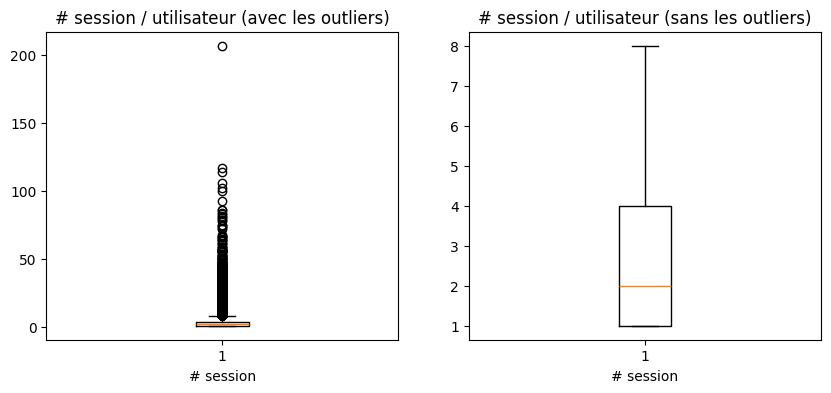

In [22]:
x = clicks.groupby(['user_id'])['session_id'].nunique()
print(
    '# session par utilisateur, Moyenne: {} - Min: {}, Max: {}.'.format(round(x.mean(), 1),
                                                              x.min(),
                                                              x.max()))

fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))
ax1.boxplot(x)
ax1.set_xlabel('# session')
ax1.set_title('# session / utilisateur (avec les outliers)')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('# session')
ax2.set_title('# session / utilisateur (sans les outliers)')
plt.show()

<Axes: title={'center': 'Distribution du nombre de sessions.'}, xlabel='session_size'>

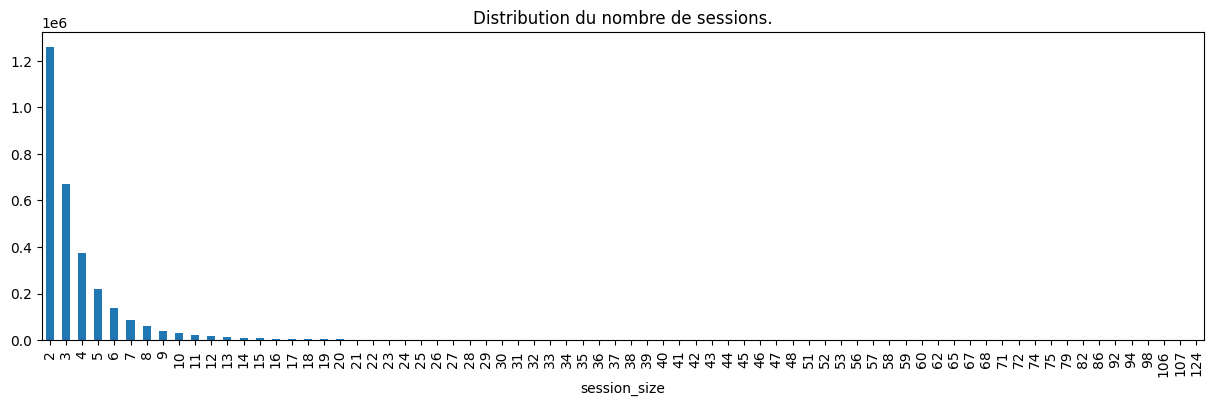

In [24]:
clicks.groupby('session_size').size().plot(kind='bar', figsize=(15, 4), title='Distribution du nombre de sessions.')

**Observations clés**
* Les utilisateurs ont consulté en moyenne 3 articles sur la période d'analyse, avec un minimum de 1 et un maximum de 207.
* Les utilisateurs consultent généralement 2 articles par session, avec un maximum de 124 ;

### 5.3.2 Localisation géographique.

<Axes: title={'center': '# Nombre utilisateurs par état'}, xlabel='click_country'>

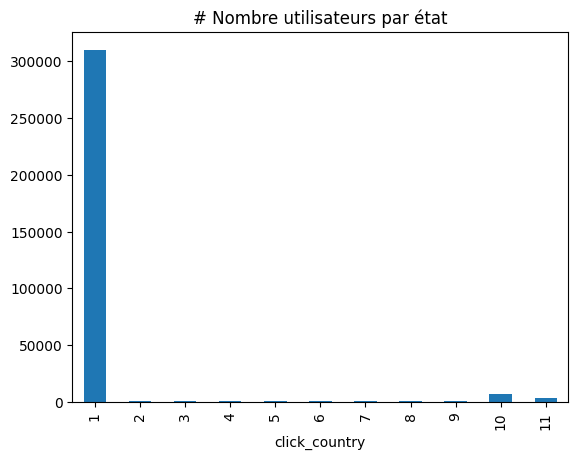

In [26]:
clicks.groupby('click_country')['user_id'].nunique().plot(kind='bar', title='# Nombre utilisateurs par état')

<Axes: title={'center': '# Nombre utilisateurs par état et région.'}, xlabel='click_country,click_region'>

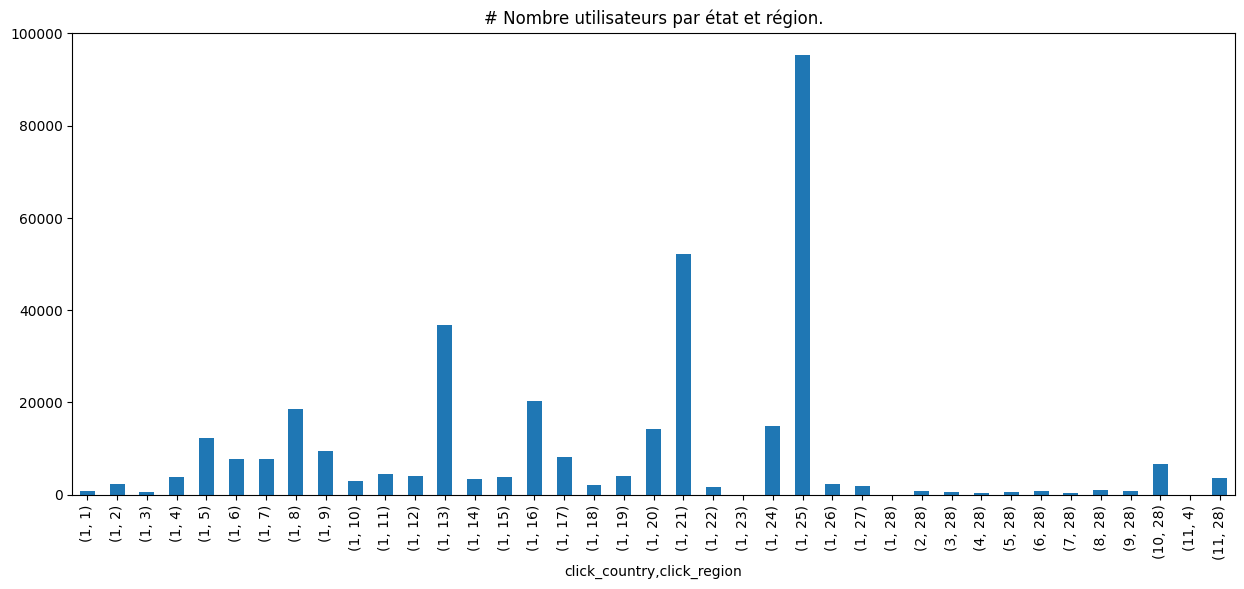

In [27]:
clicks.groupby(['click_country', 'click_region'])['user_id'].nunique().plot(kind='bar', figsize=(15, 6), title='# Nombre utilisateurs par état et région.')


**Observations clés**

La majorité des utilisateurs sont localisés dans l'état n°1 ;

Dans l'état n°1, les 3 régions les plus actives par ordre d'importance sont 25, 21 et 13.

### 5.3.3 Periodes de lecture

<Axes: title={'center': '# articles par jour'}, xlabel='session_start'>

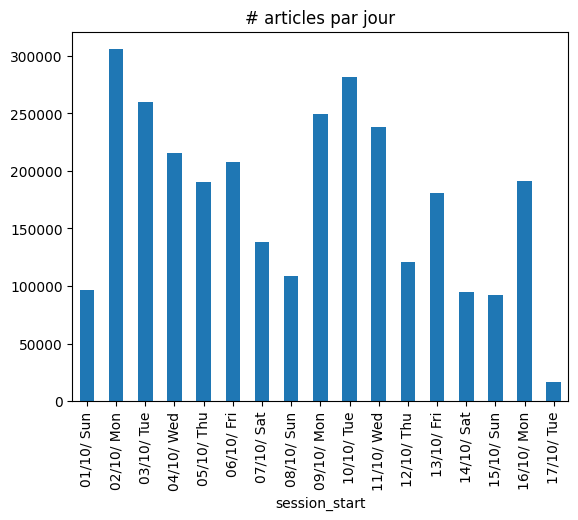

In [28]:
clicks.groupby(clicks['session_start'].dt.strftime('%d/%m/ %a')).size().plot(kind='bar', title='# articles par jour')

**Observations clés**

Les utilisateurs consultent davantage les articles en début de semaine que le week-end.

### 5.3.4 Contexte de lecture de lecture des articles.

* **click_environment** : identifiant de l'environnement (1-Facebook, 2-Application mobile, 3-Pages mobiles, 4-Web) ;
* **click_deviceGroup** : type d'appareil utilisé (1-Tablette, 2-Téléviseur, 4-Mobile, 5-Ordinateur ou 3-Vide) ;
* **click_os** : l'identifiant du système d'exploitation (1-Autre, 2-iOS, 3-Android, 4-Windows Phone, 5-Windows Mobile, 6-Windows, 7-Mac OS X, 8-Mac OS, 9- Samsung, 10-FireHbbTV, 11-ATV OS X, 12-tvOS, 13-Chrome OS, 14-Debian, 15-Symbian OS, 16-BlackBerry OS, 17-Firefox OS, 18-Android, 19-Brew MP, 20-Chromecast, 21-webOS, 22-Gentoo, 23-Solaris);

<function matplotlib.pyplot.show(close=None, block=None)>

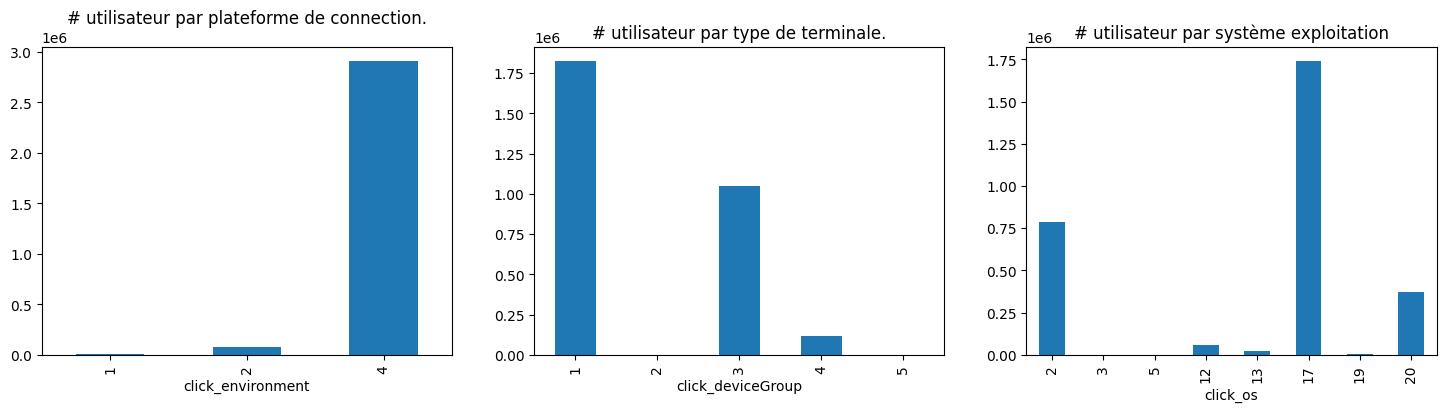

In [30]:
a = clicks.groupby('click_environment')['user_id'].count()
b = clicks.groupby('click_deviceGroup')['user_id'].count()
c = clicks.groupby('click_os')['user_id'].count()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
a.plot(kind='bar', title='# utilisateur par plateforme de connection.', ax=ax1)
b.plot(kind='bar', title='# utilisateur par type de terminale.', ax=ax2)
c.plot(kind='bar', title='# utilisateur par système exploitation', ax=ax3)
plt.show

**Observations clés**

* La lecture des articles s'effectue sur la page web de Globo.com (peu de consultation sur l'application mobile) ;
* Les utilisateurs consultent principalement les articles sur tablettes ;
* Le système d'exploitation principal est Firefox.

REMARQUE : ces données pourraient biaiser notre projet car notre MVP (Minimum Viable Product) est une application mobile : elles ne seront donc pas prises en compte dans notre système de recommandation.

### 5.3.5 Catégories des articles.

In [31]:
clicks_articles = pd.merge(clicks, articles, how='inner', on='article_id')

clicks_articles['session_start'] = pd.to_datetime(clicks_articles['session_start'].dt.strftime('%Y/%m/%d'))
clicks_articles['click_timestamp'] = pd.to_datetime(clicks_articles['click_timestamp'].dt.strftime('%Y/%m/%d'))

print(clicks_articles.shape)
clicks_articles.head()

(2988181, 17)


,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,filename,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,2017-10-01,2,157541,2017-10-01,4,3,20,1,20,2,0,281,2017-09-30,0,280
1,0,1506825423271737,2017-10-01,2,68866,2017-10-01,4,3,20,1,20,2,0,136,2017-10-01,0,226
2,1,1506825426267738,2017-10-01,2,235840,2017-10-01,4,1,17,1,16,2,0,375,2017-09-30,0,159
3,1,1506825426267738,2017-10-01,2,96663,2017-10-01,4,1,17,1,16,2,0,209,2017-09-30,0,206
4,2,1506825435299739,2017-10-01,2,119592,2017-10-01,4,1,17,1,24,2,0,247,2017-09-30,0,239


<function matplotlib.pyplot.show(close=None, block=None)>

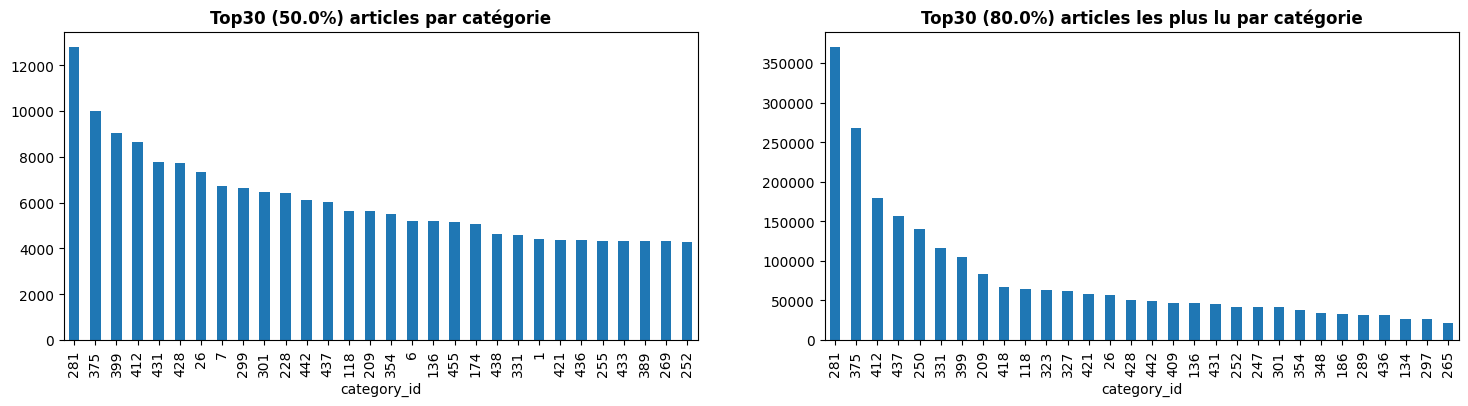

In [32]:
d = articles.groupby('category_id')['article_id'].nunique().sort_values(ascending=False)
e = clicks_articles.groupby('category_id')['article_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
d.head(30).plot(kind='bar', ax=ax1)
ax1.set_title('Top30 ({}%) articles par catégorie'.format(
    round(sum(d.head(30))/sum(d) * 100, 0)),
    fontsize=12, fontweight='bold')
e.head(30).plot(kind='bar', ax=ax2)
ax2.set_title('Top30 ({}%) articles les plus lu par catégorie'.format(
    round(sum(e.head(30))/sum(e) * 100, 0)),
    fontsize=12, fontweight='bold')
plt.show

In [33]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

print(intersection(d.head(30).index.to_list(), e.head(30).index.to_list()))

[281, 375, 399, 412, 431, 428, 26, 301, 442, 437, 118, 209, 354, 136, 331, 421, 436, 252]


**Observations clés**

* 50 % des articles publiés appartiennent aux 30 premières catégories (461 au total) ;
* Les catégories 281, 375 et 412 concentrent à la fois un grand nombre d'articles publiés (31 340 ; 68 % des articles) et un grand nombre d'articles consultés (817 994 ; 27 % des interactions) : probablement des sujets d'actualité (politique, économie, etc.).

REMARQUE : L'utilisation de cette catégorie peut limiter nos recommandations aux articles populaires.

### 5.3.6 Mots par articles.

# mots par article, Moyenne: 191.0 - Min: 0, Max: 6690.
La moitié des articles contiennent entre 159.0 et 218.0 mots


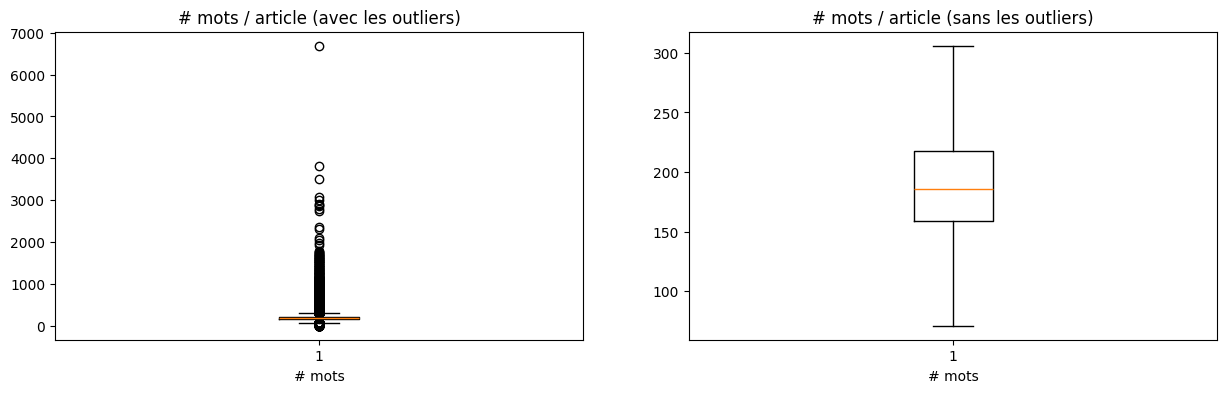

In [34]:
x = articles['words_count']
print(
    '# mots par article, Moyenne: {} - Min: {}, Max: {}.'.format(round(x.mean(), 0),
                                                              x.min(),
                                                              x.max()))
print('La moitié des articles contiennent entre {} et {} mots'.format(x.quantile(.25),
                                                                      x.quantile(.75)))

fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(15, 4))
ax1.boxplot(x)
ax1.set_xlabel('# mots')
ax1.set_title('# mots / article (avec les outliers)')
ax2.boxplot(x, showfliers=False)
ax2.set_xlabel('# mots')
ax2.set_title('# mots / article (sans les outliers)')
plt.show()


In [37]:
print('Nombre articles impliqués: ', len(articles[articles['words_count'] == 0]))
articles[articles['words_count'] == 0]

Nombre articles impliqués:  35


,article_id,category_id,created_at_ts,publisher_id,words_count
35491,35491,43,2016-08-04,0,0
38472,38472,51,2011-04-21,0,0
39043,39043,64,2014-06-30,0,0
39054,39054,64,2015-01-21,0,0
164414,164414,288,2015-03-30,0,0
206233,206233,331,2017-09-30,0,0
212323,212323,343,2010-04-19,0,0
212324,212324,343,2010-04-16,0,0
212327,212327,343,2014-08-11,0,0
212526,212526,347,2018-01-28,0,0


**Observations clés**

* Les articles comptent en moyenne environ 200 mots ;
* Nous constatons quelques légères incohérences avec les articles sans texte, principalement dans la catégorie 431.

### 5.3.7 Période de lectures

In [39]:
clicks_articles['view_recency'] = clicks_articles['click_timestamp'] - clicks_articles['created_at_ts']
clicks_articles['view_recency'] = (clicks_articles['view_recency'] / pd.Timedelta(days=1))

articles_popularity = clicks_articles.groupby('article_id', as_index=False)['click_timestamp'].count()
articles_popularity.rename(columns={'click_timestamp':'nbClicks'}, inplace=True)
articles_popularity.sort_values(by=['nbClicks'], ascending=False, inplace=True)

articles_top10 = articles_popularity.head(10)

articles_top10 = pd.merge(articles_top10, clicks_articles, on='article_id')

articles_top10 = articles_top10[articles_top10.view_recency >= 0]
print('Top10 articles interactions shape: ', articles_top10.shape)

top10_clicks_per_day = pd.DataFrame(
    articles_top10.groupby(['article_id','view_recency'], as_index=False)['click_timestamp'].count())

print('Top10 articles views shape: ', top10_clicks_per_day.shape)
top10_clicks_per_day.head()

Top10 articles interactions shape:  (240861, 19)
Top10 articles views shape:  (94, 3)


,article_id,view_recency,click_timestamp
0,96210,0.0,1252
1,96210,1.0,17613
2,96210,2.0,2663
3,96210,3.0,34
4,96210,4.0,12


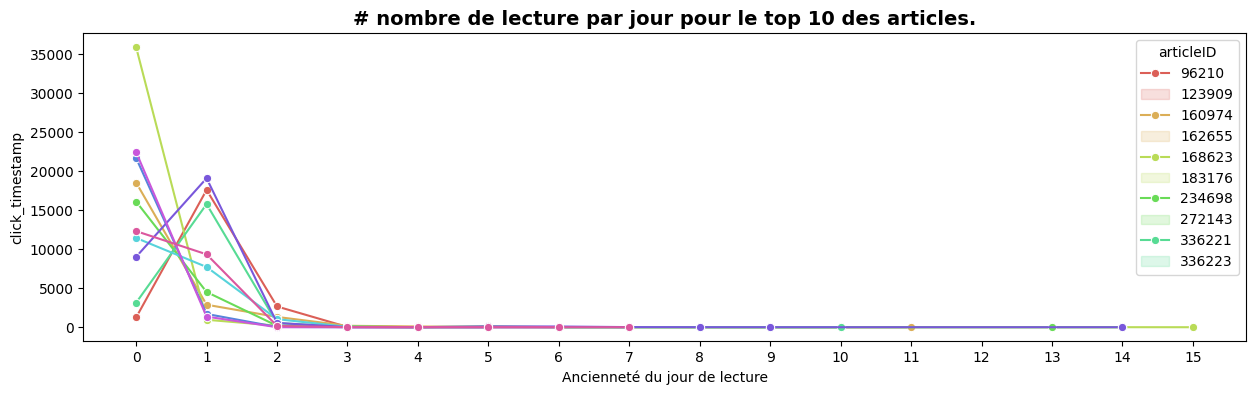

In [40]:
plt.figure(figsize=(15, 4))
palette = sns.color_palette('hls', 10)
sns.lineplot(x=top10_clicks_per_day['view_recency'],
             y=top10_clicks_per_day['click_timestamp'],
             hue=top10_clicks_per_day['article_id'],
             data=top10_clicks_per_day,
             palette=palette,
             marker='o')
plt.xticks(range(0, len(top10_clicks_per_day.view_recency.unique())+1))
plt.xlabel('Ancienneté du jour de lecture')
plt.legend(top10_clicks_per_day.article_id.unique(), title='articleID')
plt.title('# nombre de lecture par jour pour le top 10 des articles.',
          fontsize=14, fontweight='bold')
plt.show()

**Observations clés**

Dans le top 10, les articles sont consultés soit le jour même, soit le lendemain, et l'intérêt diminue très rapidement les jours suivants.

# 6. Conclusion

Dans cet ensemble de données, nous ne disposons que de données implicites (sans notation explicite) : les données sont binaires (article lu/non lu par l'utilisateur, sans notes ni notations).

* **Avantage** : elles sont faciles à collecter ;
* **Inconvénient** : elles n'indiquent pas si l'utilisateur n'aime pas un article ou si l'article consulté le concerne lui-même ou un tiers.
* **Nous n'avons pas pu créer de données exploitables supplémentaires**, telles que la durée de consultation (cela aurait peut-être permis de créer artificiellement une notation sur l'intérêt manifesté pour l'article).